# Chapter 9 – Unsupervised Learning

This notebook contains all the sample code and solutions to the exercises in chapter 9.

## Setup
This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the ```images/unsupervised_learning``` folder (if it doesn't already exist), and define the ```save_fig()``` function which is used through this notebook to save the figures in high-res for the book:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "unsupervised_learning"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures.

## Clustering

**Introduction – Classification vs Clustering**

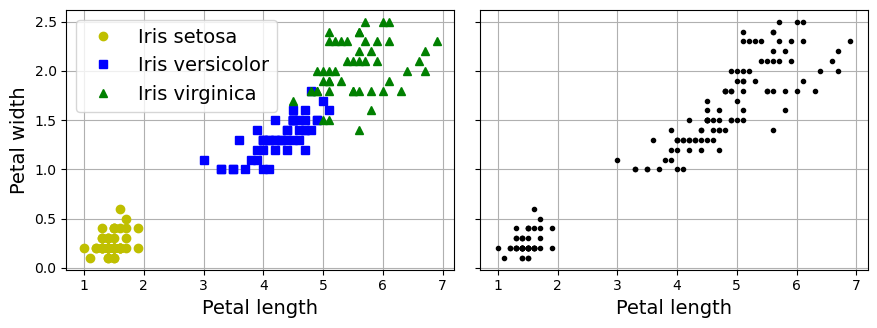

In [5]:
# extra code – this cell generates and saves Figure 9–1

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.grid()
plt.legend()

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length")
plt.tick_params(labelleft=False)
plt.gca().set_axisbelow(True)
plt.grid()

save_fig("classification_vs_clustering_plot")
plt.show()


**Note**: the next cell shows how a Gaussian mixture model (explained later in this chapter) can actually separate these clusters pretty well using all 4 features: petal length & width, and sepal length & width. This code maps each cluster to a class. Instead of hard coding the mapping, the code picks the most common class for each cluster using the ```scipy.stats.mode()``` function:

c:\Users\schre\anaconda3\envs\dev\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


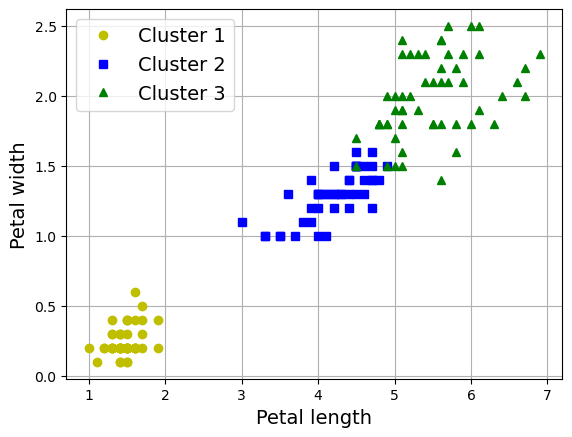

In [6]:
# extra code

import numpy as np
from scipy import stats
from sklearn.mixture import GaussianMixture

y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id])
    mapping[mode] = class_id

y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.grid()
plt.show()

What's the ratio of iris plants we assigned to the right cluster?

In [7]:
(y_pred==y).sum() / len(y_pred)

0.9666666666666667

## K-Means
**Fit and predict**

Let's train a K-Means clusterer on a dataset if blobs. It will try to find each blob's center and assign each instance to the closest blob:

In [9]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# extra code – the exact arguments of make_blobs() are not important
blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)

k = 5
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
y_pred = kmeans.fit_predict(X)

Note: Throughout this notebook, when ```n_init``` was not set when creating a KMeans estimator, I explicitly set it to ```n_init=10``` to avoid a warning about the fact that the default value for this hyperparameter will change from 10 to ```"auto"``` in Scikit-Learn 1.4.

Now let's plot them:

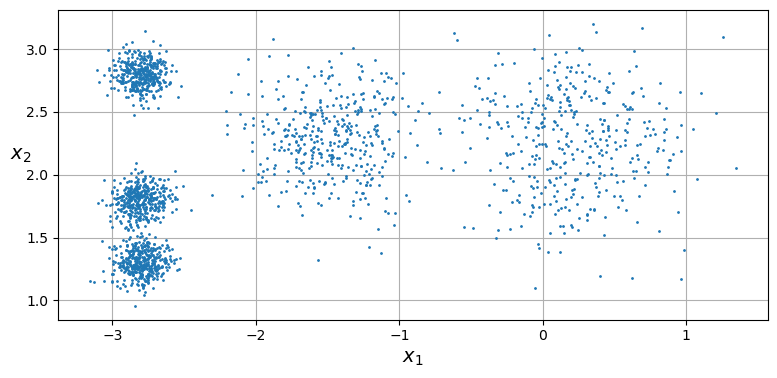

In [10]:
# extra code – this cell generates and saves Figure 9–2

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.gca().set_axisbelow(True)
plt.grid()
save_fig("blobs_plot")
plt.show()

Each instance was assigned to one of the 5 clusters:

In [11]:
y_pred

array([0, 0, 4, ..., 3, 1, 0])

In [12]:
y_pred is kmeans.labels_

True

And the following 5 *centroids* (i.e., cluster centers) were estimated:

In [13]:
kmeans.cluster_centers_

array([[-2.80214068,  1.55162671],
       [ 0.08703534,  2.58438091],
       [-1.46869323,  2.28214236],
       [-2.79290307,  2.79641063],
       [ 0.31332823,  1.96822352]])

Note that the ```KMeans``` instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the label of an instance is the index of the cluster that instance gets assigned to (they are not targets, they are predictions):

In [14]:
kmeans.labels_

array([0, 0, 4, ..., 3, 1, 0])

Of course, we can predict the labels of new instances:

In [15]:
import numpy as np

X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([4, 4, 3, 3])

**Decision Boundaries**

Let's plot the model's decision boundaries. This gives us a Voronoi diagram:

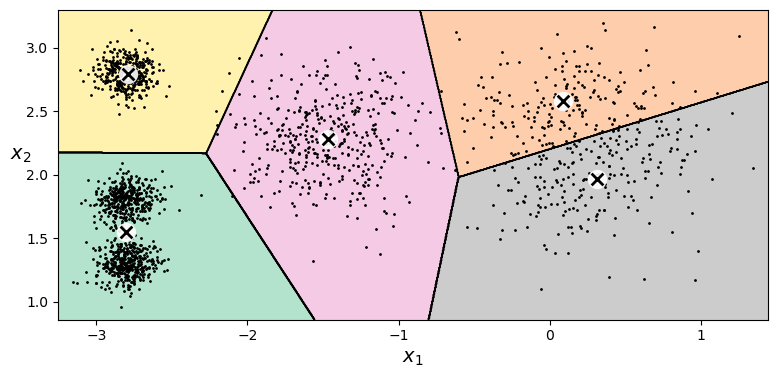

In [16]:
# extra code – this cell generates and saves Figure 9–3

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

Not bad! Some of the instances near the edges were probably assigned to the wrong cluster, but overall it looks pretty good.

**Hard Clustering *vs* Soft Clustering**

Rather than arbitrarily choosing the closest cluster for each instance, which is called *hard clustering*, it might be better to measure the distance of each instance to all 5 centroids. This is what the ```transform()``` method does:

In [17]:

kmeans.transform(X_new).round(2)

array([[2.84, 0.59, 1.5 , 2.9 , 0.31],
       [5.82, 2.97, 4.48, 5.85, 2.69],
       [1.46, 3.11, 1.69, 0.29, 3.47],
       [0.97, 3.09, 1.55, 0.36, 3.36]])

You can verify that this is indeed the Euclidian distance between each instance and each centroid:

In [18]:
# extra code
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2)
               - kmeans.cluster_centers_, axis=2).round(2)

array([[2.84, 0.59, 1.5 , 2.9 , 0.31],
       [5.82, 2.97, 4.48, 5.85, 2.69],
       [1.46, 3.11, 1.69, 0.29, 3.47],
       [0.97, 3.09, 1.55, 0.36, 3.36]])

## The K-Means Algorithm
The K-Means algorithm is one of the fastest clustering algorithms, and also one of the simplest:

* First initialize $k$ centroids randomly: e.g., $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.
The ```KMeans``` class uses an optimized initialization technique by default. To get the original K-Means algorithm (for educational purposes only), you must set ```init="random"``` and ```n_init=1```. More on this later in this chapter.

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

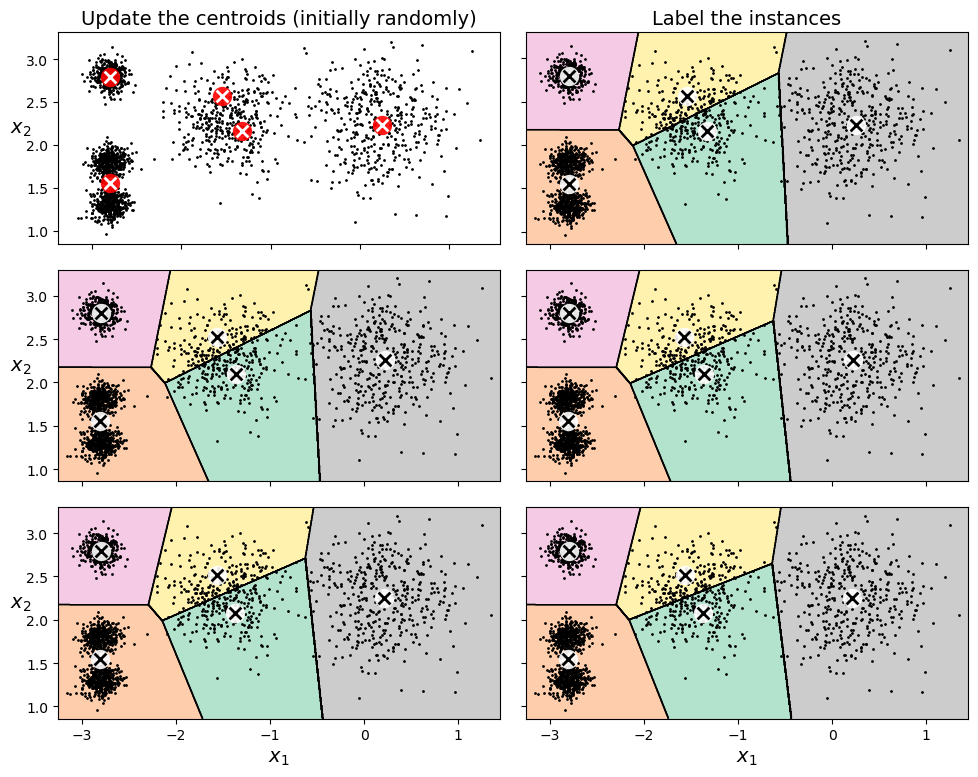

In [19]:
# extra code – this cell generates and saves Figure 9–4

kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=1,
                      random_state=5)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=2,
                      random_state=5)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=3,
                      random_state=5)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)")

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False,
                         show_ylabels=False)
plt.title("Label the instances")

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False,
                         show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False,
                         show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

**K-Means Variability**

In the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see below:

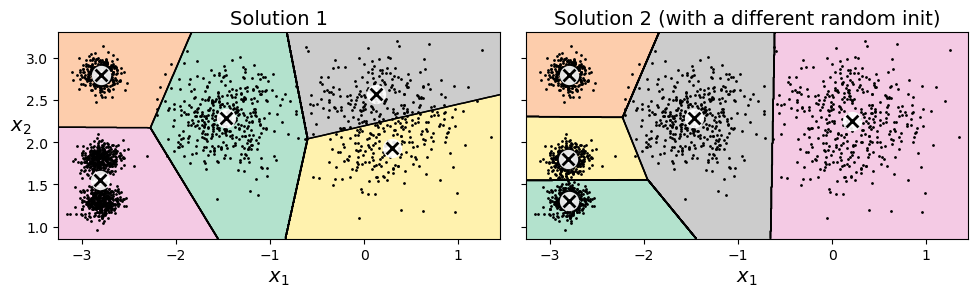

In [20]:
# extra code – this cell generates and saves Figure 9–5

def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None,
                              title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2)

kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1, random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1, random_state=9)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1",
                          "Solution 2 (with a different random init)")

save_fig("kmeans_variability_plot")
plt.show()

**K-Means Variability**

In the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see below:

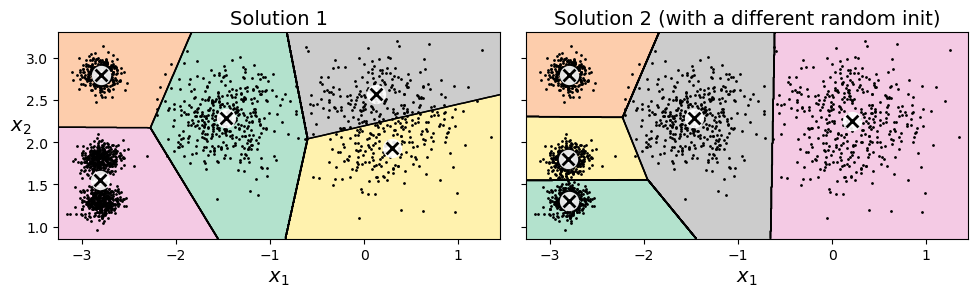

In [21]:
# extra code – this cell generates and saves Figure 9–5

def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None,
                              title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2)

kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1, random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1, random_state=9)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1",
                          "Solution 2 (with a different random init)")

save_fig("kmeans_variability_plot")
plt.show()

In [22]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1, random_state=42)

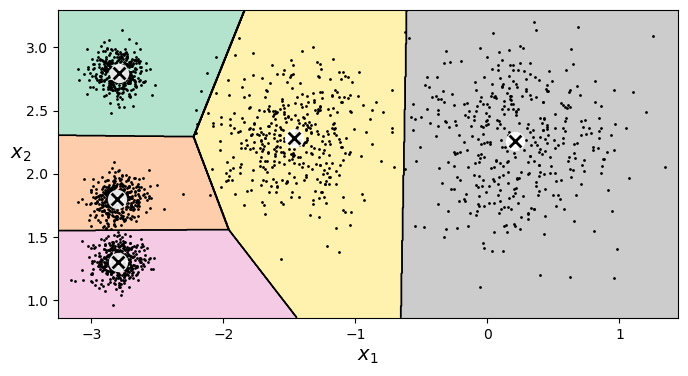

In [23]:
# extra code
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

### Inertia
To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. This is the idea behind the *inertia* metric:

In [24]:
kmeans.inertia_

211.5985372581684

In [25]:
kmeans_rnd_init1.inertia_  # extra code

219.58201503602282

In [26]:
kmeans_rnd_init2.inertia_  # extra code

211.5985372581684

As you can easily verify, inertia is the sum of the squared distances between each training instance and its closest centroid:

In [ ]:
# extra code
X_dist = kmeans.transform(X)
(X_dist[np.arange(len(X_dist)), kmeans.labels_] ** 2).sum()

The ```score()``` method returns the negative inertia. Why negative? Well, it is because a predictor's ```score()``` method must always respect the "greater is better" rule.

In [27]:
kmeans.score(X)

-211.5985372581684

### Multiple Initializations
So one approach to solve the variability issue is to simply run the K-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia.

When you set the ```n_init``` hyperparameter, Scikit-Learn runs the original algorithm n_init times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets ```n_init=10```.

In [28]:
# extra code
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                             random_state=2)
kmeans_rnd_10_inits.fit(X)

KMeans(init='random', n_clusters=5, n_init=10, random_state=2)

As you can see, we end up with the initial model, which is certainly the optimal K-Means solution (at least in terms of inertia, and assuming $k=5$).

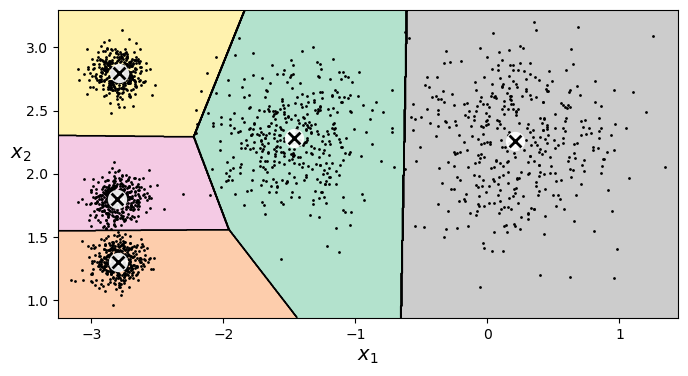

In [29]:
# extra code
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

In [30]:
kmeans_rnd_10_inits.inertia_

211.5985372581684